# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn import metrics as me

%matplotlib inline

Using TensorFlow backend.


Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [4]:
n_orientations = 8
pix_p_cell = 4
hog_size = height * width * n_orientations / (pix_p_cell * pix_p_cell)

In [9]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell),cells_per_block=(1, 1), visualise=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

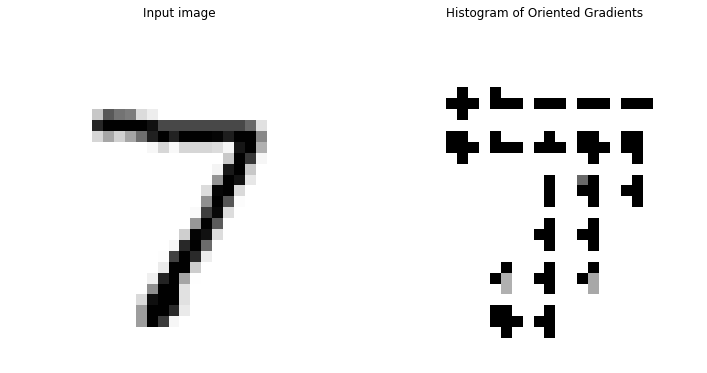

In [10]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')

Compute the HOGs for the train and test datasets

In [11]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualise=False)
print 'X_train done'

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualise=False)
print 'X_test done'

X_train done
X_test done


In [12]:
print X_train_hog[10,:]

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.95591315  0.          0.          0.          0.          0.          0.
  0.          0.99978424  0.          0.          0.          0.          0.
  0.          0.          0.99463045  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.18589276  0.          0.26167873
  0.05685836  0.          0.          0.44159743  0.05395098  0.02776458
  0.          0.17191188  0.21935355  0.48023828  0.          0.01341923
  0.08728682  0.2196774

Create the MLP

In [13]:
model = Sequential()
model.add(Dense(200, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               78600     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
Total params: 80,610.0
Trainable params: 80,610
Non-trainable params: 0.0
_________________________________________________________________


Define some constants and train the MLP

In [14]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, nb_epoch=n_epoch,
                    verbose=1, validation_data=(X_test_hog, Y_test))

/usr/local/lib/python2.7/dist-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.2545 - acc: 0.9422 - val_loss: 0.0923 - val_acc: 0.9722
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.0910 - acc: 0.9715 - val_loss: 0.0788 - val_acc: 0.9742
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.0760 - acc: 0.9758 - val_loss: 0.0749 - val_acc: 0.9757
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.0671 - acc: 0.9785 - val_loss: 0.0721 - val_acc: 0.9772
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.0595 - acc: 0.9812 - val_loss: 0.0703 - val_acc: 0.9778
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.0535 - acc: 0.9835 - val_loss: 0.0694 - val_acc: 0.9785
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0476 - acc: 0.9853 - val_loss: 0.0667 - val_acc: 0.9796
Epoch 8/10
60000/60000 [==============================] - 2s 

Show the performance of the model

Test score: 0.0653907030155
Test accuracy: 0.9806


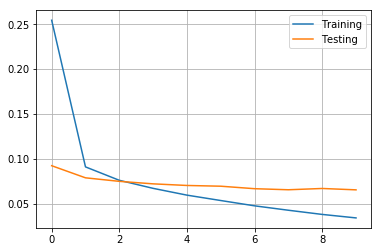

In [15]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print 'Test score:', score[0]
print 'Test accuracy:', score[1]

Confusion matrix

In [16]:
pred = model.predict_classes(X_test_hog)
me.confusion_matrix(y_test, pred)

 9056/10000 [==========================>...] - ETA: 0s

array([[ 968,    0,    2,    0,    0,    2,    3,    2,    2,    1],
       [   0, 1124,    1,    1,    1,    0,    2,    3,    3,    0],
       [   1,    1, 1013,    2,    1,    0,    2,   11,    1,    0],
       [   0,    0,    1,  996,    0,    5,    0,    4,    3,    1],
       [   1,    2,    1,    0,  962,    0,    1,    5,    1,    9],
       [   2,    1,    0,   10,    0,  870,    4,    2,    2,    1],
       [   3,    3,    0,    0,    5,    4,  942,    0,    1,    0],
       [   0,    5,    2,    0,    5,    0,    0, 1011,    2,    3],
       [   6,    0,    3,    8,    1,    1,    0,    4,  944,    7],
       [   0,    4,    1,    6,    8,    3,    0,    8,    3,  976]])